In [1]:
import numpy as np
import torch
%matplotlib widget
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# enable LaTeX rendering and font family
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'Times'

from learn_embedding.utils import *
from learn_embedding.approximators import *
from learn_embedding.covariances import *
from learn_embedding.kernels import SquaredExp
from learn_embedding.embedding import Embedding
from learn_embedding.dynamics import FirstGeometry
from learn_embedding.utils.plotting import *

In [2]:
# problem dimension
dim = 2

# obstacle
obstacle_type = 'ball' # ball, semicircle

## Torch Configuration

In [3]:
use_cuda = False # torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

## Create Model

In [4]:
num_neurons = [64]
num_layers = 2
approximator = FeedForward(dim, num_neurons*num_layers, 1)

embedding = Embedding(approximator)

stiffness = SPD(dim)

attractor = torch.tensor([0.0,0.0]).to(device)

model = FirstGeometry(embedding, attractor, stiffness).to(device)
TorchHelper.set_zero(model)

## Test

In [5]:
resolution = 100
min_ax = torch.tensor([-1,-1])
max_ax = torch.tensor([1,1])
x, y = torch.meshgrid(torch.linspace(min_ax[0], max_ax[0], resolution), torch.linspace(min_ax[1], max_ax[1], resolution), indexing='xy')
grid_x = torch.stack((torch.ravel(x), torch.ravel(y)), dim=1).to(device).requires_grad_(True)
grid_xr = torch.stack((torch.ravel(x[10::10,10::10]), torch.ravel(y[10::10,10::10])), dim=1).to(device).requires_grad_(True)
theta = torch.linspace(0, 2*torch.pi, steps=50).to(device)

### Potential

In [6]:
potential = model.potential(grid_x).reshape(resolution, -1).cpu().detach().numpy()

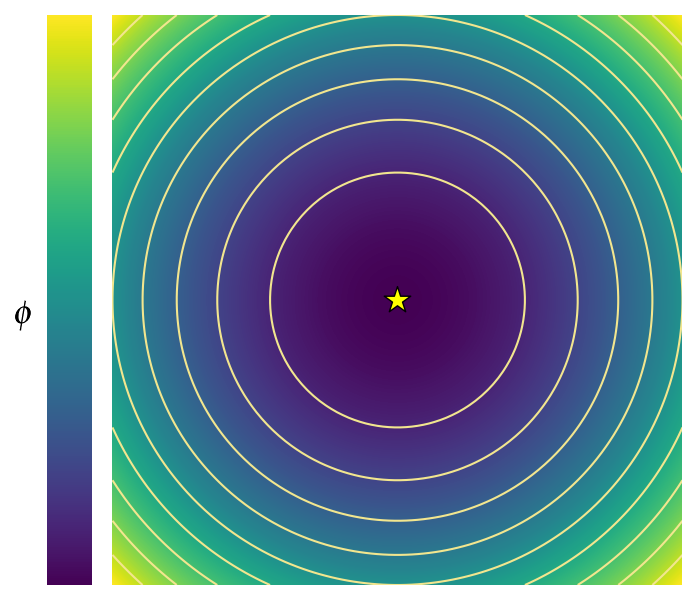

In [7]:
fig, ax = plt.subplots(figsize=(7, 6))
im = ax.contourf(x, y, potential, 500, cmap="viridis")
ax.contour(x, y, potential, 10, cmap=None, colors='#f2e68f')
ax.scatter(attractor[0].cpu(), attractor[1].cpu(), s=400, edgecolors='k', c='yellow', marker="*", zorder=20)
colorbar(im, fig, ax, label='\phi', size='8%')
beautify(fig, ax)
fig.savefig('../media/local_first_potential.png', format='png', dpi=100, bbox_inches="tight")

### Vector Field & Streamlines

In [8]:
obstacle_radius = 0.1 # 0.05 , 0.1
obstacle = torch.tensor([[-0.4,-0.4]])
# obstacle = Obstacles.square(center=torch.tensor([-30,20]), a=20, b=20, res=10)
# obstacle = Obstacles.semi_circle(radius=0.2, center=torch.tensor([-0.4,   -0.4]), rot=torch.tensor(torch.pi/4), res=50)
decay = 5e-1
lengthscale = np.sqrt(-0.5*obstacle_radius**2/np.log(decay))
embedding.local_deformation = KernelDeformation(obstacle.to(device), 
                                                weights = 1.0*torch.ones(obstacle.shape[0]).to(device), 
                                                kernel=SquaredExp(l=lengthscale)).to(device)

field = model(grid_x)
x_field = field[:, 0].reshape(resolution, -1).cpu().detach().numpy()
y_field = field[:, 1].reshape(resolution, -1).cpu().detach().numpy()

x0 = torch.tensor([[-0.9, -0.85]]).to(device).requires_grad_(True)
streamlines = Integrator.first_order(dynamics=model,x0=x0,T=6, dt=0.01).cpu().detach().numpy()

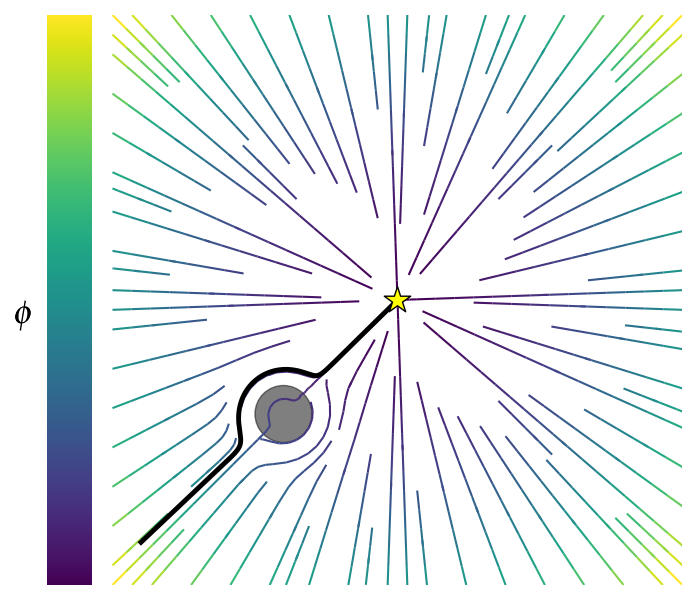

In [9]:
fig, ax = plt.subplots(figsize=(7, 6))
ax.streamplot(x.numpy(), y.numpy(), x_field, y_field, color=potential, cmap="viridis", linewidth=1.5, arrowstyle='-', arrowsize=1.5)
ax.scatter(attractor[0].cpu(), attractor[1].cpu(), s=400, edgecolors='k', c='yellow', marker="*", zorder=10)
for i in range(streamlines.shape[1]):
    ax.plot(streamlines[:, i, 0], streamlines[:, i, 1], color='k', linewidth=3.5)
if hasattr(embedding, 'local_deformation'):
    for i in range(0,obstacle.shape[0],4):
        circ = plt.Circle((obstacle[i, 0], obstacle[i, 1]), obstacle_radius,
                            color='k', fill='grey', alpha=0.5)
        ax.add_patch(circ)
colorbar(im, fig, ax, label='\phi', size='8%')
beautify(fig, ax)
fig.savefig('../media/local_first_field.png', format='png', dpi=100, bbox_inches="tight") 

### Embedding

In [10]:
grid_embedding = embedding(grid_x)
x_embedding = grid_embedding[:, 0].reshape(resolution, -1).cpu().detach().numpy()
y_embedding = grid_embedding[:, 1].reshape(resolution, -1).cpu().detach().numpy()
z_embedding = grid_embedding[:, 2].reshape(resolution, -1).cpu().detach().numpy()
test_embedding = []
for i in range(streamlines.shape[1]):
    test_embedding.append(embedding(torch.from_numpy(streamlines[:,i,:dim]).float().to(device).requires_grad_(True)).cpu().detach().numpy())
attractor_embedding = embedding(attractor.unsqueeze(0)).squeeze().cpu().detach().numpy()

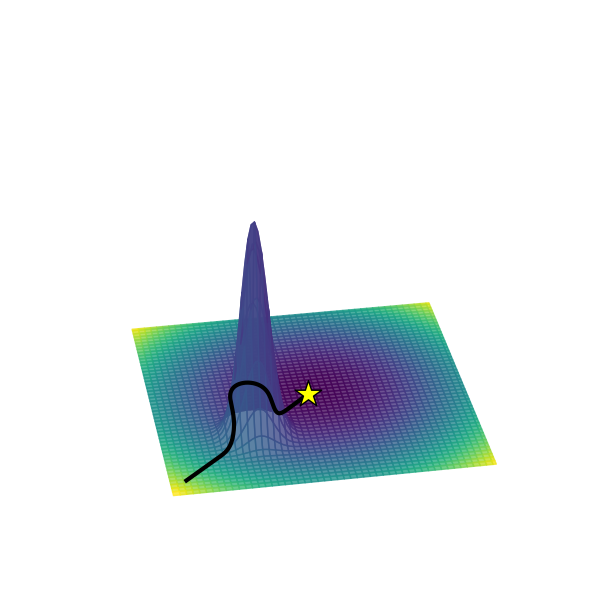

In [17]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection="3d", computed_zorder=False)
norm = plt.Normalize(vmin=potential.min(), vmax=potential.max())
colors = plt.cm.viridis(norm(potential))
im = ax.plot_surface(x_embedding, y_embedding, z_embedding, cmap='jet', edgecolor='none', antialiased=True, alpha=0.8, facecolors=colors)
for traj in test_embedding:
    ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], color='k', linewidth=3.0)
ax.scatter(attractor_embedding[0], attractor_embedding[1], attractor_embedding[2], s=400, edgecolors='k', c='yellow', marker="*", zorder=10)
ax.axis('off')
ax.view_init(elev=30, azim=-100)
fig.patch.set_visible(False)
fig.tight_layout()
fig.savefig('../media/local_first_embedding.png', format='png', dpi=100, bbox_inches="tight")

### Metric

In [12]:
metric = model.embedding.pullmetric(grid_embedding, model.embedding.jacobian(grid_x, grid_embedding))
det_metric = metric.det().reshape(resolution, -1).detach().cpu().numpy()

red_embedding = embedding(grid_xr)
metric_r = embedding.pullmetric(red_embedding, embedding.jacobian(grid_xr, red_embedding))
evals,evecs = torch.linalg.eigh(metric_r)

x_range = (max_ax[0] - min_ax[0]).abs()
y_range = (max_ax[1] - min_ax[1]).abs()
evals /= 5*torch.tensor([y_range/x_range,1.0]).to(device)

ellipses = torch.stack((evals[:, 0].unsqueeze(-1)*theta.cos(), evals[:, 1].unsqueeze(-1)*theta.sin()), dim=2)
ellipses = torch.bmm(evecs, ellipses.permute(0, 2, 1)).permute(0, 2, 1).detach().cpu()/10
ellipses_x = x[10::10,10::10].ravel().unsqueeze(-1) + ellipses[:, :, 0]
ellipses_y = y[10::10,10::10].ravel().unsqueeze(-1) + ellipses[:, :, 1]

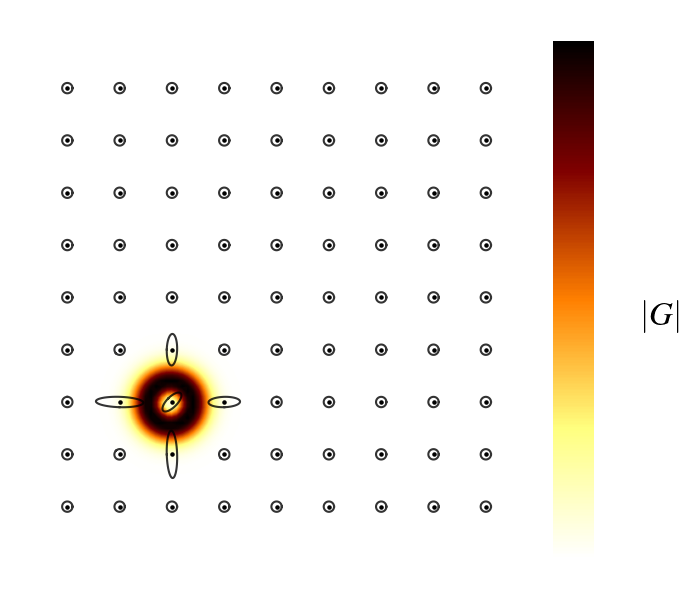

In [18]:
fig, ax = plt.subplots(figsize=(7, 6))
im = ax.contourf(x, y, det_metric, 500, cmap="afmhot_r")
ax.scatter(x[10::10, 10::10], y[10::10, 10::10], color="k", s=5)
for i in range(ellipses.shape[0]):
    ax.plot(ellipses_x[i, :], ellipses_y[i, :], color="k", linewidth=1.5, alpha=0.8)
colorbar(im, fig, ax, label='|G|', size='8%', pos="right")
beautify(fig, ax)
fig.tight_layout()
fig.savefig('../media/local_first_detmetric.png', format='png', dpi=100, bbox_inches="tight")

### Trajectory Metric Deformation

In [14]:
step = 40
eval_scale = 10
x_sampled = torch.from_numpy(streamlines[:, 0, :dim]).float().to(device).requires_grad_(True)
v_sampled = torch.from_numpy(streamlines[:, 0, dim:]).float().to(device).requires_grad_(True)
sampled_embedding = embedding(x_sampled)

metric_sampled = model.embedding.pullmetric(sampled_embedding, model.embedding.jacobian(x_sampled, sampled_embedding))
metric_evals,metric_evecs = torch.linalg.eigh(metric_sampled.inverse())
metric_ellipses = torch.stack((metric_evals[:, 0].unsqueeze(-1)*theta.cos(), metric_evals[:, 1].unsqueeze(-1)*theta.sin()), dim=2)
metric_ellipses = torch.bmm(metric_evecs, metric_ellipses.permute(0, 2, 1)).permute(0, 2, 1).detach().cpu()/eval_scale
step_metric = 50

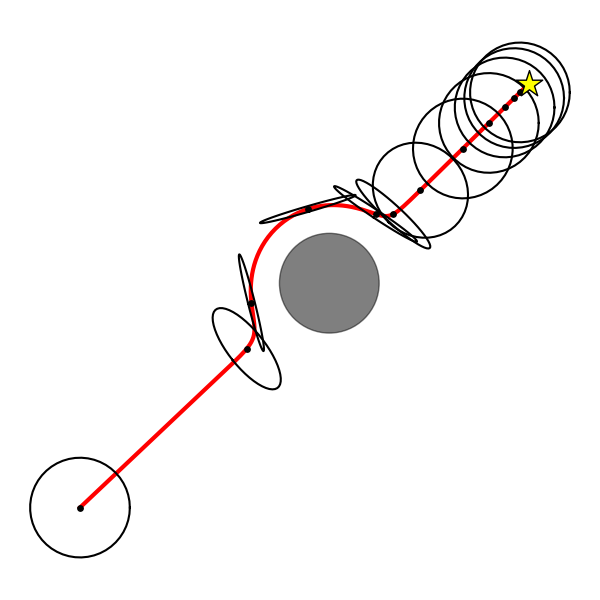

In [15]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(x_sampled[:, 0].detach().cpu(), x_sampled[:, 1].detach().cpu(), color='r', linewidth='3')
ax.scatter(x_sampled[::step_metric, 0].detach().cpu(), x_sampled[::step_metric, 1].detach().cpu(), color="k", s=15, zorder=10)
for i in range(0, metric_ellipses.shape[0], step_metric):
    ax.plot(x_sampled[i, 0].detach().cpu() + metric_ellipses[i, :, 0],
            x_sampled[i, 1].detach().cpu() + metric_ellipses[i, :, 1], color="k", linewidth=1.5)  
ax.scatter(attractor[0].cpu(), attractor[1].cpu(), s=400, edgecolors='k', c='yellow', marker="*", zorder=20)
if hasattr(embedding, 'local_deformation'):
    for i in range(0,obstacle.shape[0],4):
        circ = plt.Circle((obstacle[i, 0], obstacle[i, 1]), obstacle_radius,
                            color='k', fill='grey', alpha=0.5)
        ax.add_patch(circ)
beautify(fig, ax)
fig.savefig('../media/local_first_invmetric.png', format='png', dpi=100, bbox_inches="tight")